# PCA (Principal Component Analysis)

This notebook demonstrates how to use the PCA implementation in `rice_ml.unsupervised_learning.pca`.

We will:
- load a real dataset (Iris),
- standardize features,
- fit PCA and examine explained variance,
- visualize the 2D projection.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Robust repo-root -> src path injection (works from examples/.../)
cwd = os.getcwd()
repo_root = os.path.abspath(os.path.join(cwd, "../../.."))  # if notebook is in examples/Unsupervised_Learning/PCA/
src_path = os.path.join(repo_root, "src")

if not os.path.isdir(os.path.join(src_path, "rice_ml")):
    raise RuntimeError("Could not find 'src/rice_ml'. Run this notebook inside the repo.")

if src_path not in sys.path:
    sys.path.insert(0, src_path)

from rice_ml.processing.preprocessing import standardize
from rice_ml.unsupervised_learning.pca import PCA

np.random.seed(42)


## 2. Load data and standardize features

PCA is sensitive to feature scale. To make each feature comparable, we apply **z-score standardization**:

\[
X_{\text{std}} = \frac{X - \mu}{\sigma}
\]

We will use the classic Iris dataset (150 samples, 4 numeric features). The labels are **not used for training** (PCA is unsupervised), but later we can use them for visualization.


In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

X_std, params = standardize(X, return_params=True)

print("X shape:", X.shape)
print("Features:", feature_names)
print("Mean after standardize (approx):", X_std.mean(axis=0))
print("Std after standardize (approx):", X_std.std(axis=0))


X shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Mean after standardize (approx): [-1.65238193e-15 -1.86239912e-15 -1.68901929e-15 -1.44254978e-15]
Std after standardize (approx): [1. 1. 1. 1.]


## 3. Fit PCA and inspect explained variance

We fit PCA on the standardized data and examine:

- `explained_variance_ratio_`: how much variance each principal component explains
- cumulative explained variance: how many components are needed to capture most information

We will start by keeping **all components** to inspect the variance breakdown.


n_components_: 4
Explained variance ratio: [0.72962445 0.22850762 0.03668922 0.00517871]
Cumulative explained variance: [0.72962445 0.95813207 0.99482129 1.        ]


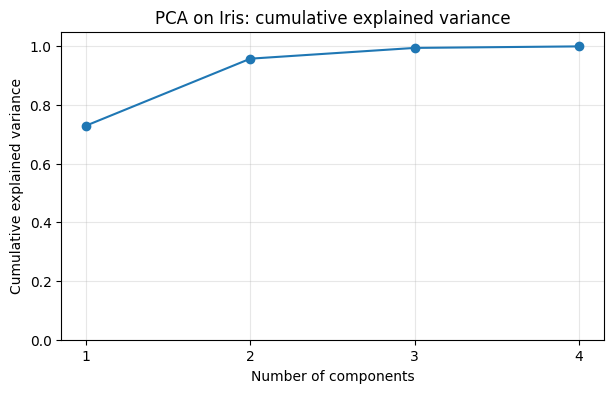

In [3]:

pca_full = PCA(n_components=None, whiten=False).fit(X_std)

evr = pca_full.explained_variance_ratio_
cum_evr = np.cumsum(evr)

print("n_components_:", pca_full.n_components_)
print("Explained variance ratio:", evr)
print("Cumulative explained variance:", cum_evr)

# Plot cumulative explained variance
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(cum_evr) + 1), cum_evr, marker="o")
plt.xticks(np.arange(1, len(cum_evr) + 1))
plt.ylim(0, 1.05)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA on Iris: cumulative explained variance")
plt.grid(True, alpha=0.3)
plt.show()


## 4. Project Iris into 2D (PC1 vs PC2)

Since the first two principal components explain ~96% of the variance, we can
visualize the dataset in 2D by projecting onto (PC1, PC2).

Even though PCA is unsupervised, Iris
has ground-truth species labels `y`. We will color points by `y` only as a
reference to see whether the 2D PCA projection separates classes reasonably well.


Z2 shape: (150, 2)
Explained variance ratio (2D): [0.72962445 0.22850762]
Cumulative explained variance (2D): 0.9581320720000169


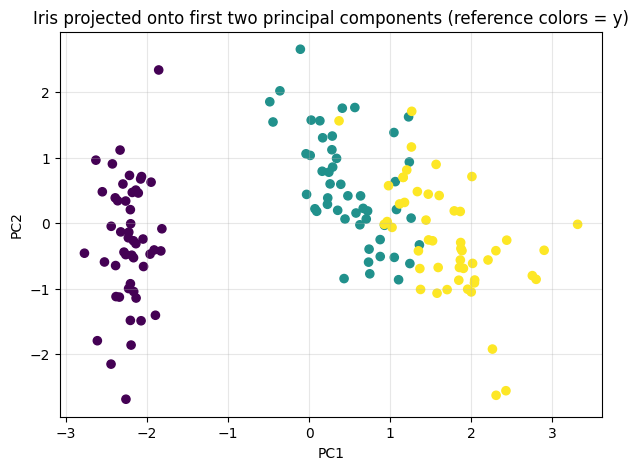

In [4]:
# Fit PCA with 2 components and transform
pca2 = PCA(n_components=2, whiten=False).fit(X_std)
Z2 = pca2.transform(X_std)

print("Z2 shape:", Z2.shape)
print("Explained variance ratio (2D):", pca2.explained_variance_ratio_)
print("Cumulative explained variance (2D):", np.sum(pca2.explained_variance_ratio_))

# Scatter plot in PC space, colored by ground truth labels (reference only)
plt.figure(figsize=(7, 5))
plt.scatter(Z2[:, 0], Z2[:, 1], c=y, s=35)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Iris projected onto first two principal components (reference colors = y)")
plt.grid(True, alpha=0.3)
plt.show()


## 5. Automatically choose the number of components (variance threshold)

A common practical rule is to keep the smallest number of principal components
that explain at least a target fraction of the variance (e.g., 95%).

Here we fit PCA with `n_components=0.95`, which means:
> keep the smallest k such that cumulative explained variance ≥ 0.95.

We then check the chosen `k` and compare it to our earlier observation that
PC1+PC2 already explain about ~96% of the variance.


In [5]:
pca95 = PCA(n_components=0.95, whiten=False).fit(X_std)
Z95 = pca95.transform(X_std)

print("Chosen n_components_ (>=95% variance):", pca95.n_components_)
print("Explained variance ratio:", pca95.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca95.explained_variance_ratio_))
print("Z95 shape:", Z95.shape)


Chosen n_components_ (>=95% variance): 2
Explained variance ratio: [0.72962445 0.22850762]
Cumulative explained variance: [0.72962445 0.95813207]
Z95 shape: (150, 2)


## 6. Reconstruct the original features from the low-dimensional representation

PCA is a lossy compression when we keep fewer than all components.
To see how much information is lost, we can:

1. Project data into the PCA space (here: 2D).
2. Reconstruct it back to the original feature space using `inverse_transform`.
3. Measure reconstruction error (e.g., mean squared error).

Because we standardized the data before PCA, the reconstruction error is measured
in standardized units.


In [6]:
# Use the PCA model that keeps >=95% variance (which picked 2 components)
Z2_auto = Z95
X_std_rec = pca95.inverse_transform(Z2_auto)

# Reconstruction error (MSE) in standardized space
mse_rec = np.mean((X_std - X_std_rec) ** 2)
rmse_rec = np.sqrt(mse_rec)

print("Reconstruction MSE (standardized space):", mse_rec)
print("Reconstruction RMSE (standardized space):", rmse_rec)

#per-feature reconstruction MSE
mse_per_feature = np.mean((X_std - X_std_rec) ** 2, axis=0)
print("Per-feature MSE:", mse_per_feature)
print("Feature names:", feature_names)


Reconstruction MSE (standardized space): 0.04186792799998361
Reconstruction RMSE (standardized space): 0.2046165389209377
Per-feature MSE: [0.07740136 0.00908068 0.01627005 0.06471963]
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


## 7. PCA as a preprocessing step for clustering (K-Means)

PCA is often used before clustering to (1) reduce dimensionality, (2) remove noise, and
(3) make distance-based methods more stable.

Here we compare:
- **K-Means on standardized 4D features**
vs
- **K-Means on PCA-reduced 2D representation**

Even though K-Means is unsupervised and does not use labels during training, Iris provides `y` (3 classes).
We treat `y` as a **reference** to roughly evaluate how well clusters align with known classes.
We report:
- **ARI (Adjusted Rand Index)**: label-permutation invariant clustering similarity score.
- **Best-mapped accuracy**: best permutation mapping from cluster IDs → class IDs.


Z2 shape: (150, 2)
Explained variance ratio (2D): [0.72962445 0.22850762]
Cumulative explained variance (2D): 0.9581320720000169

KMeans on 4D:
  inertia: 139.82049635974977
  n_iter: 6
  cluster sizes: {np.int64(0): np.int64(50), np.int64(1): np.int64(47), np.int64(2): np.int64(53)}

KMeans on PCA(2D):
  inertia: 115.1864705074268
  n_iter: 10
  cluster sizes: {np.int64(0): np.int64(55), np.int64(1): np.int64(45), np.int64(2): np.int64(50)}

 sklearn not available, skip ARI/confusion_matrix.


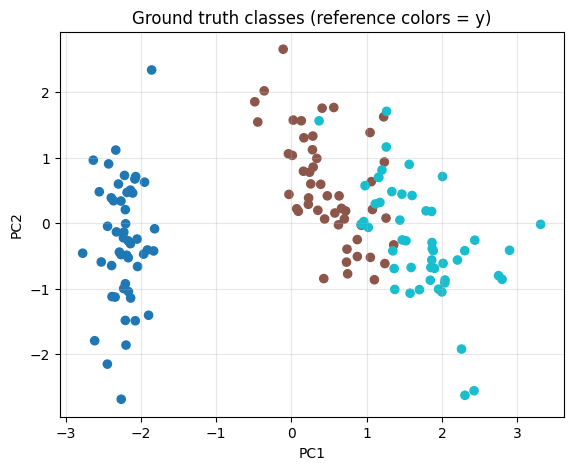

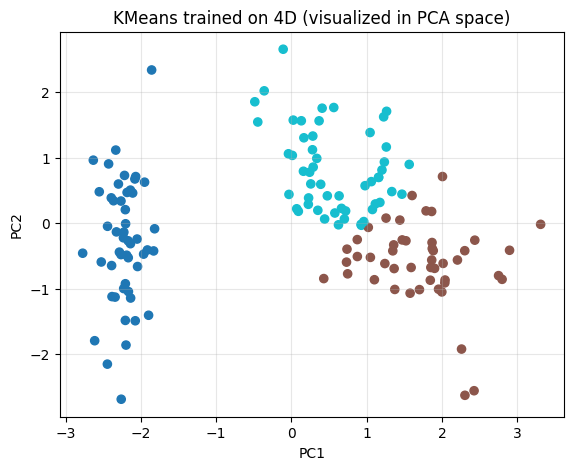

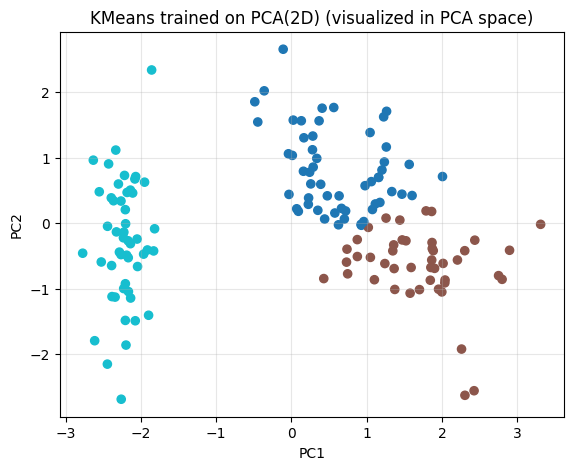

In [11]:

from rice_ml.unsupervised_learning.k_means_clustering import KMeans

# --- ensure standardized input ---
X_std = standardize(X)

# --- PCA to 2D ---
pca2 = PCA(n_components=2, whiten=False).fit(X_std)
Z2 = pca2.transform(X_std)
print("Z2 shape:", Z2.shape)
print("Explained variance ratio (2D):", pca2.explained_variance_ratio_)
print("Cumulative explained variance (2D):", np.sum(pca2.explained_variance_ratio_))

# --- helper: best-mapped accuracy (cluster ids -> class ids) ---
def best_mapped_accuracy(y_true: np.ndarray, cluster_labels: np.ndarray):
    y_true = np.asarray(y_true, dtype=int)
    cluster_labels = np.asarray(cluster_labels, dtype=int)

    clusters = np.unique(cluster_labels)
    classes = np.unique(y_true)

    # If counts differ, fall back to majority vote per cluster (still gives a usable reference metric)
    if len(clusters) != len(classes):
        mapping = {}
        for c in clusters:
            mask = cluster_labels == c
            majority = np.bincount(y_true[mask]).argmax()
            mapping[int(c)] = int(majority)
        y_pred = np.array([mapping[int(c)] for c in cluster_labels], dtype=int)
        acc = float(np.mean(y_pred == y_true))
        return acc, mapping, y_pred

    best_acc = -1.0
    best_map = None
    best_pred = None

    for perm in itertools.permutations(classes, len(clusters)):
        mapping = {int(clusters[i]): int(perm[i]) for i in range(len(clusters))}
        y_pred = np.array([mapping[int(c)] for c in cluster_labels], dtype=int)
        acc = float(np.mean(y_pred == y_true))
        if acc > best_acc:
            best_acc = acc
            best_map = mapping
            best_pred = y_pred

    return best_acc, best_map, best_pred

# --- helper: plotting in PCA space ---
def plot_in_pca_space(Z2: np.ndarray, labels: np.ndarray, title: str):
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    idx_map = {lab: i for i, lab in enumerate(uniq)}
    denom = max(1, len(uniq) - 1)
    colors = [plt.cm.tab10(idx_map[lab] / denom) for lab in labels]

    plt.figure(figsize=(6.5, 5))
    plt.scatter(Z2[:, 0], Z2[:, 1], c=colors, s=35)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- KMeans on 4D standardized ---
km4 = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300, tol=1e-4).fit(X_std)
labels4 = km4.labels_
print("\nKMeans on 4D:")
print("  inertia:", km4.inertia_)
print("  n_iter:", km4.n_iter_)
print("  cluster sizes:", dict(zip(*np.unique(labels4, return_counts=True))))

# --- KMeans on 2D PCA ---
km2 = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300, tol=1e-4).fit(Z2)
labels2 = km2.labels_
print("\nKMeans on PCA(2D):")
print("  inertia:", km2.inertia_)
print("  n_iter:", km2.n_iter_)
print("  cluster sizes:", dict(zip(*np.unique(labels2, return_counts=True))))

# --- reference metrics (ARI + best-mapped accuracy) ---
try:
    from sklearn.metrics import adjusted_rand_score, confusion_matrix

    ari4 = adjusted_rand_score(y, labels4)
    acc4, map4, pred4 = best_mapped_accuracy(y, labels4)

    ari2 = adjusted_rand_score(y, labels2)
    acc2, map2, pred2 = best_mapped_accuracy(y, labels2)

    print("\nReference metrics (using y only for evaluation):")
    print("KMeans 4D  -> ARI:", ari4, " best-mapped acc:", acc4, " mapping:", map4)
    print("KMeans 2D  -> ARI:", ari2, " best-mapped acc:", acc2, " mapping:", map2)

    print("\nConfusion matrix (4D, after mapping):\n", confusion_matrix(y, pred4))
    print("\nConfusion matrix (2D, after mapping):\n", confusion_matrix(y, pred2))

except Exception as e:
    print("\n sklearn not available, skip ARI/confusion_matrix.")

# --- Visual comparisons (all plotted in PCA space for a fair 2D view) ---
plot_in_pca_space(Z2, y, "Ground truth classes (reference colors = y)")
plot_in_pca_space(Z2, labels4, "KMeans trained on 4D (visualized in PCA space)")
plot_in_pca_space(Z2, labels2, "KMeans trained on PCA(2D) (visualized in PCA space)")


## 8. Interpretation

### (1) Explained variance
- The first principal component (PC1) explains about **73.0%** of the variance.
- The first two components together explain about **95.8%** of the variance.
- This means we can reduce **4D → 2D** while keeping most of the information in the dataset.

### (2) 2D projection visualization
- In the PC1–PC2 plot, the three Iris classes form visible structure:
  - **Setosa** is clearly separated from the others.
  - **Versicolor** and **Virginica** overlap more, but still show partial separation.
- This is consistent with the fact that Setosa is easier to classify, while Versicolor/Virginica are harder due to feature overlap.

### (3) Reconstruction quality (information loss)
- Using only 2 components, the reconstruction error in standardized space is:
  - **MSE ≈ 0.0419**
  - **RMSE ≈ 0.2046**
- Since features were standardized (unit variance), an RMSE around 0.20 indicates the reconstruction is generally close, but not perfect—some detail is lost.

### (4) Which features lose the most information?
Per-feature reconstruction MSE:
- sepal length: **0.0774**
- sepal width: **0.0091**
- petal length: **0.0163**
- petal width: **0.0647**

Interpretation:
- The largest reconstruction errors are for **sepal length** and **petal width**, meaning these two features lose more detail when compressing into 2 PCs.
- **Sepal width** has very low reconstruction error, suggesting it is well-captured by the top principal directions in this dataset.

PCA provides a strong dimensionality reduction for Iris: **2 PCs retain most variance** and preserve the main class structure visually, with relatively small reconstruction error. However, overlap between Versicolor and Virginica remains, showing that PCA (being linear and unsupervised) does not guarantee perfect class separation.

### PCA as a preprocessing step for clustering
We compared:
- **KMeans on 4D**, then visualized in PCA space
- **KMeans on PCA(2D)**, visualized in the same PCA space

Key observations:
- Visually, both approaches produce broadly similar cluster structure in PCA space.
- Training KMeans on PCA(2D) can be faster and may reduce noise, because we keep only the dominant variance directions.

**Important note on inertia:**  
The inertia values from 4D vs 2D are **not directly comparable**, because inertia is computed in the space where KMeans is trained. Reducing dimensionality changes distances (typically shrinking them), so a smaller inertia in 2D does not automatically mean “better clustering”.

### Bottom line
- PCA is extremely useful here for **visualization**, **compression**, and as an optional **preprocessing step** before algorithms like KMeans.
- For Iris, **2 components (≥95% variance)** is a reasonable choice that preserves most structure while enabling clean 2D plots.
- If we want a quantitative comparison, we could compute metrics like **ARI** or a mapped-label accuracy (using `y` only as a reference), but PCA itself remains fully unsupervised.